# Install Libraries

In [296]:
!pip install tensorflow pandas numpy sklearn

  Using cached sklearn-0.0.post10.tar.gz (3.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [297]:
!pip install pandas scikit-learn

In [298]:
!pip install lime shap

In [299]:
import pandas as pd
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Precision, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, AUC
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from keras.layers import SimpleRNN, Dense
import random
import tensorflow as tf
from google.colab import drive

In [300]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [301]:
file_path_internal = '/content/drive/MyDrive/CKD/Data/AU Raw/eGFR 12-09-2023.xlsx'
file_path_external = '/content/drive/MyDrive/CKD/Data/JP Raw/ROUTE_proteinuria_dataset.xlsx'

# External Data

## 1. Additional Pre-steps

In [393]:
df = pd.read_excel(file_path_external)

Unknown extension is not supported and will be removed


In [394]:
df.dtypes

ID                               int64
gender                           int64
age                              int64
SBP                            float64
BMI                            float64
etiology of CKD                  int64
Hb                             float64
Alb                            float64
Cr                             float64
eGFR                           float64
CKD_stage                        int64
CKD category                   float64
dip-stick proteinuria          float64
proteinuria                    float64
urinary occult blood           float64
UPCR                           float64
UPCR category                  float64
hypertension                     int64
prevalence of CVD                int64
diabetes                         int64
use of RAASi                     int64
use of CCB                       int64
use of diuretics                 int64
eGFR(0M)                       float64
50%eGFR                        float64
eGFR(6M)                 

In [395]:
df.isna().sum()

ID                               0
gender                           0
age                              0
SBP                             18
BMI                            137
etiology of CKD                  0
Hb                               2
Alb                             12
Cr                               0
eGFR                             0
CKD_stage                        0
CKD category                    88
dip-stick proteinuria           16
proteinuria                     16
urinary occult blood            16
UPCR                            88
UPCR category                   88
hypertension                     0
prevalence of CVD                0
diabetes                         0
use of RAASi                     0
use of CCB                       0
use of diuretics                 0
eGFR(0M)                         0
50%eGFR                          0
eGFR(6M)                       202
50%eGFR_reached(6M)            202
eGFR(12M)                      332
50%eGFR_reached(12M)

In [396]:
# ID                               0
# gender                           0 ##
# age                              0 ##
# SBP                             18
# BMI                            137
# Hb                               2 #
# Alb                             12 #
# Cr                               0 ##
# eGFR                             0 ##
# dip-stick proteinuria           16
# proteinuria                     16
# urinary occult blood            16
# UPCR                            88 # can it sub UACR?
# UPCR category                   88
# hypertension                     0
# prevalence of CVD                0
# diabetes                         0
# use of RAASi                     0
# use of CCB                       0
# use of diuretics                 0
# HD or PD                       929

In [397]:
columns_to_flatten = ['eGFR(0M)', 'eGFR(6M)', 'eGFR(12M)', 'eGFR(18M)', 'eGFR(24M)', 'eGFR(30M)', 'eGFR(36M)', 'eGFR(last visit)']

# Use melt to flatten these columns
df_melted = pd.melt(df, id_vars=['ID', 'age', 'gender', 'Cr'], value_vars=columns_to_flatten, var_name='Time', value_name='eGFR')

# Display the melted DataFrame
df_melted

This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.


,ID,age,gender,Cr,Time,eGFR
0,10101,74,2,1.20,eGFR(0M),34.146986
1,10102,39,1,1.31,eGFR(0M),50.451187
2,10103,74,1,4.95,eGFR(0M),9.804696
3,10201,57,1,0.84,eGFR(0M),73.570568
4,10202,32,1,0.87,eGFR(0M),83.558305
...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554
9100,160110,62,2,4.74,eGFR(last visit),4.664378
9101,160111,60,1,1.42,eGFR(last visit),41.861876
9102,160112,52,1,2.13,eGFR(last visit),28.931595


In [398]:
len(set(df_melted['ID']))

1138

In [399]:
df_melted.isna().sum()

ID           0
age          0
gender       0
Cr           0
Time         0
eGFR      2608
dtype: int64

In [400]:
import math

def amend_age(row):
    time_str = row['Time']
    months = 0
    if time_str == 'eGFR(6M)':
        months = 6
    elif time_str == 'eGFR(12M)':
        months = 12
    elif time_str == 'eGFR(18M)':
        months = 18
    elif time_str == 'eGFR(24M)':
        months = 24
    elif time_str == 'eGFR(30M)':
        months = 30
    elif time_str == 'eGFR(36M)':
        months = 36
    elif time_str == 'eGFR(last visit)':
        months = 42  # Adding 42 months for 'last visit'

    amended_age = row['age'] + (months / 12.0)

    # Round down the amended age
    return math.floor(amended_age)

# Apply the function to the DataFrame
df_melted['amended_age'] = df_melted.apply(amend_age, axis=1)
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age
0,10101,74,2,1.20,eGFR(0M),34.146986,74
1,10102,39,1,1.31,eGFR(0M),50.451187,39
2,10103,74,1,4.95,eGFR(0M),9.804696,74
3,10201,57,1,0.84,eGFR(0M),73.570568,57
4,10202,32,1,0.87,eGFR(0M),83.558305,32
...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55


In [401]:
(73.570568/(194*(57**-0.287)))**(-1/1.094)

0.8399999971425922

In [402]:
import numpy as np

# Assuming df_melted is your DataFrame
def calculate_SCr(row):
    age_factor = row['amended_age'] ** -0.287
    gender_factor = 0.739 if row['gender'] == 2 else 1  # assuming 'female' and 'male' are the gender labels
    eGFR = row['eGFR']

    SCr = ((eGFR / (194 * age_factor * gender_factor)) ** (-1 / 1.094))
    return SCr

# Apply the function to create a new column 'Calculated_SCr'
df_melted['Calculated_SCr'] = df_melted.apply(calculate_SCr, axis=1)

# Display the DataFrame to check the results
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age,Calculated_SCr
0,10101,74,2,1.20,eGFR(0M),34.146986,74,1.200000
1,10102,39,1,1.31,eGFR(0M),50.451187,39,1.310000
2,10103,74,1,4.95,eGFR(0M),9.804696,74,4.950000
3,10201,57,1,0.84,eGFR(0M),73.570568,57,0.840000
4,10202,32,1,0.87,eGFR(0M),83.558305,32,0.870000
...,...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74,1.879483
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65,7.660000
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63,1.370000
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55,1.990000


In [403]:
df_melted['Cr_umol_per_L'] = df_melted['Calculated_SCr'] * 88.4
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age,Calculated_SCr,Cr_umol_per_L
0,10101,74,2,1.20,eGFR(0M),34.146986,74,1.200000,106.080000
1,10102,39,1,1.31,eGFR(0M),50.451187,39,1.310000,115.804000
2,10103,74,1,4.95,eGFR(0M),9.804696,74,4.950000,437.580000
3,10201,57,1,0.84,eGFR(0M),73.570568,57,0.840000,74.256000
4,10202,32,1,0.87,eGFR(0M),83.558305,32,0.870000,76.908000
...,...,...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74,1.879483,166.146322
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65,7.660000,677.144000
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63,1.370000,121.108000
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55,1.990000,175.916000


In [404]:
141 * ((115.804000	* 0.0113 / 0.9) ** -1.209) * ((0.993) ** 39)

68.18759529340964

In [405]:
# Assuming df_melted is your DataFrame with 'gender', 'age', and 'Cr' columns
def calculate_eGFR_CKD_EPI(row):
    if row['gender'] == 2:
        if row['Cr_umol_per_L'] <= 62:
            return 144 * ((row['Cr_umol_per_L'] * 0.0113 / 0.7) ** -0.329) * ((0.993) ** row['amended_age'])
        else:
            return 144 * ((row['Cr_umol_per_L'] * 0.0113 / 0.7) ** -1.209) * ((0.993) ** row['amended_age'])
    else:  # Assuming gender is male if not female
        if row['Cr_umol_per_L'] <= 80:
            return 141 * ((row['Cr_umol_per_L'] * 0.0113 / 0.9) ** -0.411) * ((0.993) ** row['amended_age'])
        else:
            return 141 * ((row['Cr_umol_per_L'] * 0.0113 / 0.9) ** -1.209) * ((0.993) ** row['amended_age'])

# Apply the function to create a new column 'eGFR_CKD_EPI'
df_melted['eGFR_CKD_EPI'] = df_melted.apply(calculate_eGFR_CKD_EPI, axis=1)

# Display the DataFrame to check the results
df_melted

,ID,age,gender,Cr,Time,eGFR,amended_age,Calculated_SCr,Cr_umol_per_L,eGFR_CKD_EPI
0,10101,74,2,1.20,eGFR(0M),34.146986,74,1.200000,106.080000,44.685607
1,10102,39,1,1.31,eGFR(0M),50.451187,39,1.310000,115.804000,68.187595
2,10103,74,1,4.95,eGFR(0M),9.804696,74,4.950000,437.580000,10.688884
3,10201,57,1,0.84,eGFR(0M),73.570568,57,0.840000,74.256000,97.237557
4,10202,32,1,0.87,eGFR(0M),83.558305,32,0.870000,76.908000,114.245526
...,...,...,...,...,...,...,...,...,...,...
9099,160109,71,2,1.90,eGFR(last visit),20.901554,74,1.879483,166.146322,25.976778
9100,160110,62,2,4.74,eGFR(last visit),4.664378,65,7.660000,677.144000,5.061998
9101,160111,60,1,1.42,eGFR(last visit),41.861876,63,1.370000,121.108000,54.572415
9102,160112,52,1,2.13,eGFR(last visit),28.931595,55,1.990000,175.916000,36.758771


In [406]:
df_melted.isna().sum()

ID                   0
age                  0
gender               0
Cr                   0
Time                 0
eGFR              2608
amended_age          0
Calculated_SCr    2608
Cr_umol_per_L     2608
eGFR_CKD_EPI      2608
dtype: int64

In [407]:
df_melted.dropna(subset=['eGFR_CKD_EPI'], inplace=True)

In [408]:
#df_melted[df_melted['ID'] == 10101]

In [409]:
# Only Checking Kidney Failure Instances

# Filter the DataFrame to include only rows where eGFR_CKD_EPI is less than 15
filtered_df = df_melted[df_melted['eGFR_CKD_EPI'] < 15]

# Group by gender and count the number of cases
grouped_df = filtered_df.groupby('gender').size()

# Display the count of male and female cases
print("Number of male cases where eGFR_CKD_EPI < 15:", grouped_df.get(1, 0))
print("Number of female cases where eGFR_CKD_EPI < 15:", grouped_df.get(2, 0))

Number of male cases where eGFR_CKD_EPI < 15: 689
Number of female cases where eGFR_CKD_EPI < 15: 394


In [410]:
# Drop the specified columns
df_melted.drop(['age', 'Cr', 'eGFR', 'Calculated_SCr', 'Cr_umol_per_L'], axis=1, inplace=True)
df_melted

,ID,gender,Time,amended_age,eGFR_CKD_EPI
0,10101,2,eGFR(0M),74,44.685607
1,10102,1,eGFR(0M),39,68.187595
2,10103,1,eGFR(0M),74,10.688884
3,10201,1,eGFR(0M),57,97.237557
4,10202,1,eGFR(0M),32,114.245526
...,...,...,...,...,...
9099,160109,2,eGFR(last visit),74,25.976778
9100,160110,2,eGFR(last visit),65,5.061998
9101,160111,1,eGFR(last visit),63,54.572415
9102,160112,1,eGFR(last visit),55,36.758771


In [411]:
# Rename columns
df_melted.rename(columns={
    'amended_age': 'AGE',
    'gender': 'SEX',
    'eGFR_CKD_EPI': 'eGFR'
}, inplace=True)

df_melted

,ID,SEX,Time,AGE,eGFR
0,10101,2,eGFR(0M),74,44.685607
1,10102,1,eGFR(0M),39,68.187595
2,10103,1,eGFR(0M),74,10.688884
3,10201,1,eGFR(0M),57,97.237557
4,10202,1,eGFR(0M),32,114.245526
...,...,...,...,...,...
9099,160109,2,eGFR(last visit),74,25.976778
9100,160110,2,eGFR(last visit),65,5.061998
9101,160111,1,eGFR(last visit),63,54.572415
9102,160112,1,eGFR(last visit),55,36.758771


## 2. Applying Inclusion Criteria

In [412]:
df = df_melted

In [413]:
df.dtypes

ID        int64
SEX       int64
Time     object
AGE       int64
eGFR    float64
dtype: object

In [414]:
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 1138


In [415]:
# Filter in Age 18 and over
df = df[df['AGE'] >= 18]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 1138


In [416]:
# Sort by date
df.sort_values('ID', inplace=True)

In [417]:
# Filter out patients with less than 3 eGFR measurements
df = df[df.groupby('ID').ID.transform('count') > 2]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 939


In [418]:
# Assuming df is your DataFrame
time_order = ['eGFR(0M)', 'eGFR(6M)', 'eGFR(12M)', 'eGFR(18M)', 'eGFR(24M)', 'eGFR(30M)', 'eGFR(36M)', 'eGFR(last visit)']
df['Time'] = pd.Categorical(df['Time'], categories=time_order, ordered=True)

# Sort the DataFrame
df = df.sort_values(['ID', 'Time'])
df

,ID,SEX,Time,AGE,eGFR
0,10101,2,eGFR(0M),74,44.685607
1138,10101,2,eGFR(6M),74,33.702778
2276,10101,2,eGFR(12M),75,30.641655
3414,10101,2,eGFR(18M),75,31.129969
4552,10101,2,eGFR(24M),76,26.807906
...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304
5688,160112,1,eGFR(24M),54,35.502557
6826,160112,1,eGFR(30M),54,33.338440
7964,160112,1,eGFR(36M),55,36.758771


In [419]:
# Filter to only include first readings between 15 (patient in a dialysis) and 59
filter_1 = df.groupby('ID')['eGFR'].apply(lambda x: 15 <= x.iloc[0] <= 59) #logic is same as (first value >=15) and (first value <=59)
df = df[df['ID'].map(filter_1)] # Applying filter
print("Total number of unique ids:", len(df['ID'].unique()))

grouped = df.groupby('ID')['eGFR'].first()
print(grouped)

Total number of unique ids: 597
ID
10101     44.685607
10203     31.094233
10206     45.191558
10208     57.647030
10209     57.791605
            ...    
150403    23.555764
150404    40.630789
160108    30.437540
160111    53.370833
160112    34.579257
Name: eGFR, Length: 597, dtype: float64


In [420]:
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 597


In [421]:
# • Patients who were already on dialysis were excluded, as determined by
# whether their first eGFR reading was taken at a dialysis centre prior
# to their first eGFR reading < 15 #CHECK

In [422]:
df_copy = df

In [423]:
# Filter the DataFrame to include only rows where eGFR_CKD_EPI is less than 15
filtered_df = df[df['eGFR'] < 15]

# Group by gender and count the number of cases
grouped_df = filtered_df.groupby('SEX').size()

# Display the count of male and female cases
print("Number of male cases where eGFR_CKD_EPI < 15:", grouped_df.get(1, 0))
print("Number of female cases where eGFR_CKD_EPI < 15:", grouped_df.get(2, 0))

Number of male cases where eGFR_CKD_EPI < 15: 369
Number of female cases where eGFR_CKD_EPI < 15: 142


## 3.Kidney Failure Criteria

In [424]:
patient_ids = []

# Loop over unique IDs in the dataframe
for id in df['ID'].unique():

    # Extract records for this patient excluding the first reading (eGFR(0M))
    patient_df = df[(df['ID'] == id) & (df['Time'] != 'eGFR(0M)')]

    # Find instances where eGFR is less than 15
    low_eGFR = patient_df[patient_df['eGFR'] < 15]

    # Check if there are at least two such instances
    if low_eGFR.shape[0] >= 2:
        patient_ids.append(id)

# Print the total number of patients
print(f"Total number of patients: {len(patient_ids)}")

Total number of patients: 162


In [425]:
# Filter the dataframe to only include patients of interest
df = df[df['ID'].isin(patient_ids)]

In [426]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")

Total number of unique ids: 162
Total number of rows: 983


In [427]:
# Filter the DataFrame to include only rows where eGFR_CKD_EPI is less than 15
filtered_df = df[df['eGFR'] < 15]

# Group by gender and count the number of cases
grouped_df = filtered_df.groupby('SEX').size()

# Display the count of male and female cases
print("Number of male cases where eGFR_CKD_EPI < 15:", grouped_df.get(1, 0))
print("Number of female cases where eGFR_CKD_EPI < 15:", grouped_df.get(2, 0))

Number of male cases where eGFR_CKD_EPI < 15: 365
Number of female cases where eGFR_CKD_EPI < 15: 142


In [428]:
# Export data
# df.to_csv('/content/drive/MyDrive/CKD/filtered_data.csv', index=False)

In [429]:
# Sort the DataFrame by the ID column
df_unique = df.drop_duplicates(subset='ID')
sorted_df = df_unique.sort_values('ID')
subset = sorted_df['ID']
# Write the sorted DataFrame to a new CSV file
# subset.to_csv('/content/drive/MyDrive/CKD/filtered_IDs.csv', index=False)

### Further Analysis on Patient IDs with Kidney Failure

In [430]:
# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Convert the Series to a DataFrame
records_per_id_df = records_per_id.reset_index()

# Rename the columns
records_per_id_df.columns = ['ID', 'Number of Records']

# Sort DataFrame by 'Number of Records' in descending order
records_per_id_df = records_per_id_df.sort_values(by='Number of Records', ascending=False)

# Display the DataFrame
print(records_per_id_df)

         ID  Number of Records
0     10302                  8
40   150307                  8
29   110213                  8
30   110203                  8
31    90102                  8
..      ...                ...
148   80307                  3
146   20303                  3
145  140108                  3
144   90301                  3
161   80714                  3

[162 rows x 2 columns]


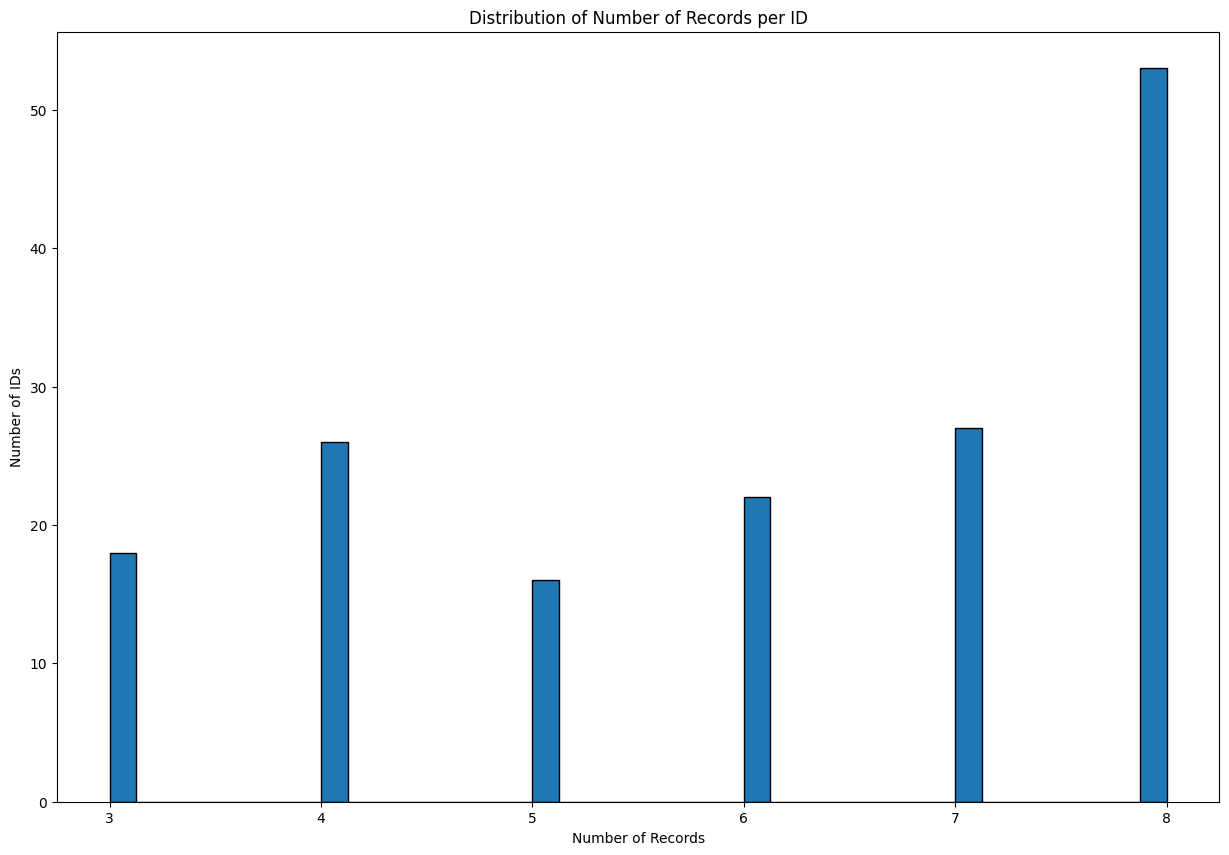

In [431]:
import matplotlib.pyplot as plt

# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Create a histogram
plt.hist(records_per_id, bins=40, edgecolor='black')

# Set the title and labels
plt.title('Distribution of Number of Records per ID')
plt.xlabel('Number of Records')
plt.ylabel('Number of IDs')

# Show the plot
plt.show()

## 4.Obtain Final Dataframe with the added Kidney Failure Target Variable

In [432]:
df = df_copy

In [433]:
# Create a new column 'Kidney Failure'. If the patient ID is in the list, assign 1, else 0
df['Kidney_Failure'] = df['ID'].isin(patient_ids).astype(int)
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ID,SEX,Time,AGE,eGFR,Kidney_Failure
0,10101,2,eGFR(0M),74,44.685607,0
1138,10101,2,eGFR(6M),74,33.702778,0
2276,10101,2,eGFR(12M),75,30.641655,0
3414,10101,2,eGFR(18M),75,31.129969,0
4552,10101,2,eGFR(24M),76,26.807906,0
...,...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304,0
5688,160112,1,eGFR(24M),54,35.502557,0
6826,160112,1,eGFR(30M),54,33.338440,0
7964,160112,1,eGFR(36M),55,36.758771,0


In [434]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")
print("Total number of unique ids with KF:", len(df[df['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(df[df['Kidney_Failure']==1])}")

Total number of unique ids: 597
Total number of rows: 3930
Total number of unique ids with KF: 162
Total number of rows with KF: 983


In [435]:
# Filter out the rows where Kidney_Failure is 1
kidney_failure_df = df[df['Kidney_Failure'] == 1]

# Find unique male and female IDs with kidney failure
unique_male_ids = kidney_failure_df[kidney_failure_df['SEX'] == 1]['ID'].unique()
unique_female_ids = kidney_failure_df[kidney_failure_df['SEX'] == 2]['ID'].unique()

# Count these unique IDs
male_cases = len(unique_male_ids)
female_cases = len(unique_female_ids)

# Print the counts
print(f"Number of unique male cases of kidney failure: {male_cases}")
print(f"Number of unique female cases of kidney failure: {female_cases}")

Number of unique male cases of kidney failure: 118
Number of unique female cases of kidney failure: 44


In [436]:
df

,ID,SEX,Time,AGE,eGFR,Kidney_Failure
0,10101,2,eGFR(0M),74,44.685607,0
1138,10101,2,eGFR(6M),74,33.702778,0
2276,10101,2,eGFR(12M),75,30.641655,0
3414,10101,2,eGFR(18M),75,31.129969,0
4552,10101,2,eGFR(24M),76,26.807906,0
...,...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304,0
5688,160112,1,eGFR(24M),54,35.502557,0
6826,160112,1,eGFR(30M),54,33.338440,0
7964,160112,1,eGFR(36M),55,36.758771,0


In [437]:
#df.sort_values(by=['ID', 'COLLECTED'], inplace=True)
df.isna().sum()

ID                0
SEX               0
Time              0
AGE               0
eGFR              0
Kidney_Failure    0
dtype: int64

In [438]:
# Truncate onwards for each ID where the eGFR first drops below 15.
mask = df.groupby('ID')['eGFR'].transform(lambda x: x.ge(15).cummin())
df = df.loc[mask]
df

,ID,SEX,Time,AGE,eGFR,Kidney_Failure
0,10101,2,eGFR(0M),74,44.685607,0
1138,10101,2,eGFR(6M),74,33.702778,0
2276,10101,2,eGFR(12M),75,30.641655,0
3414,10101,2,eGFR(18M),75,31.129969,0
4552,10101,2,eGFR(24M),76,26.807906,0
...,...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304,0
5688,160112,1,eGFR(24M),54,35.502557,0
6826,160112,1,eGFR(30M),54,33.338440,0
7964,160112,1,eGFR(36M),55,36.758771,0


In [439]:
TEST_df = df.copy()
TEST_df

,ID,SEX,Time,AGE,eGFR,Kidney_Failure
0,10101,2,eGFR(0M),74,44.685607,0
1138,10101,2,eGFR(6M),74,33.702778,0
2276,10101,2,eGFR(12M),75,30.641655,0
3414,10101,2,eGFR(18M),75,31.129969,0
4552,10101,2,eGFR(24M),76,26.807906,0
...,...,...,...,...,...,...
4550,160112,1,eGFR(18M),53,35.133304,0
5688,160112,1,eGFR(24M),54,35.502557,0
6826,160112,1,eGFR(30M),54,33.338440,0
7964,160112,1,eGFR(36M),55,36.758771,0


In [440]:
# STATS
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")
print("Total number of unique ids with KF:", len(df[df['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(df[df['Kidney_Failure']==1])}")

Total number of unique ids: 597
Total number of rows: 3388
Total number of unique ids with KF: 162
Total number of rows with KF: 456


In [441]:
# Filter out the rows where Kidney_Failure is 1
kidney_failure_df = df[df['Kidney_Failure'] == 1]

# Find unique male and female IDs with kidney failure
unique_male_ids = kidney_failure_df[kidney_failure_df['SEX'] == 1]['ID'].unique()
unique_female_ids = kidney_failure_df[kidney_failure_df['SEX'] == 2]['ID'].unique()

# Count these unique IDs
male_cases = len(unique_male_ids)
female_cases = len(unique_female_ids)

# Print the counts
print(f"Number of unique male cases of kidney failure: {male_cases}")
print(f"Number of unique female cases of kidney failure: {female_cases}")

Number of unique male cases of kidney failure: 118
Number of unique female cases of kidney failure: 44


# Internal Data

## 2. Applying Inclusion Criteria

In [442]:
df = pd.read_excel(file_path_internal)

In [443]:
df.dtypes

COLLECTED               datetime64[ns]
ID                               int64
SEX                             object
AGE                              int64
INPATIENT/OUTPATIENT            object
eGFR                            object
dtype: object

In [444]:
# Replace '> 90' with 91 and convert to integer
print(set(df['eGFR']))
df['eGFR'] = np.where(df['eGFR'].str.strip() == "> 90", 91, df['eGFR']).astype(int)
print("Total number of unique ids:", len(df['ID'].unique()))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, '> 90   '}
Total number of unique ids: 149491


In [445]:
# Filter in Age 18 and over
df = df[df['AGE'] >= 18]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 149491


In [446]:
# Sort by date
df.sort_values('COLLECTED', inplace=True)

In [447]:
# Filter out patients with less than 3 eGFR measurements
df = df[df.groupby('ID').ID.transform('count') > 2]
print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 56632


In [448]:
# Filter to only include first readings between 15 (patient in a dialysis) and 59
filter_1 = df.groupby('ID')['eGFR'].apply(lambda x: 15 <= x.iloc[0] <= 59) #logic is same as (first value >=15) and (first value <=59)
df = df[df['ID'].map(filter_1)] # Applying filter
print("Total number of unique ids:", len(df['ID'].unique()))

grouped = df.groupby('ID')['eGFR'].first()
print(grouped)

Total number of unique ids: 10072
ID
2         23
7         53
10        54
14        48
19        29
          ..
149209    36
149248    46
149264    57
149302    53
149311    55
Name: eGFR, Length: 10072, dtype: int64


In [449]:
# Patients who had two eGFR readings on the same day after their first eGFR reading < 15 were considered to be on dialysis and excluded

# Group the data by 'ID' and get the date when the first eGFR < 15 for each patient
first_low_egfr_date = df[df['eGFR'] < 15].groupby('ID')['COLLECTED'].min()

# Join the dates of first low eGFR readings to the original DataFrame
df = df.join(first_low_egfr_date.rename('first_low_egfr_date'), on='ID')

# Only keep rows where 'Date' is after the 'first_low_egfr_date'
df_after_first_low_egfr = df[df['COLLECTED'] > df['first_low_egfr_date']]

# Identify patients who have 2 or more readings on any day after their first eGFR reading < 15
patients_on_dialysis = df_after_first_low_egfr.groupby(['ID', 'COLLECTED']).filter(lambda x: len(x) >= 2)['ID'].unique()

# Filter these patients out from the original DataFrame
df = df[~df['ID'].isin(patients_on_dialysis)]

df.drop('first_low_egfr_date', axis=1, inplace=True)

print("Total number of unique ids:", len(df['ID'].unique()))

Total number of unique ids: 10064



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [450]:
# • Patients who were already on dialysis were excluded, as determined by
# whether their first eGFR reading was taken at a dialysis centre prior
# to their first eGFR reading < 15 #CHECK

In [451]:
df_copy = df

## 3. Kidney Failure Criteria

In [452]:
# Kidney failure was determined as follows: UIDs with two eGFR readings < 15 at least 30 days apart, with one eGFR reading > 15 immediately preceding these.
# This eliminates cases where patients are already in kidney failure — only patients that progress from CKD to kidney failure are included.

import itertools

patient_ids = []

# Loop over unique IDs in the dataframe
for id in df['ID'].unique():

    # Extract records for this patient excluding the first reading
    patient_df = df[df['ID'] == id]

    # Find instances where eGFR is less than 15
    low_eGFR = patient_df[patient_df['eGFR'] < 15].sort_values(by='COLLECTED')

    # Check if there are at least two such instances
    if low_eGFR.shape[0] >= 2:

        # Loop through the data and find if there are any two dates at least 90 days apart
        found_90_days_apart = False
        for date1, date2 in itertools.combinations(low_eGFR['COLLECTED'], 2):
            time_diff = (date2 - date1).days

            # If time difference is at least 90 days, set the flag to True and break
            if time_diff >= 30: #90  #355 patients at 29 days
                found_90_days_apart = True
                break

        if found_90_days_apart:
            patient_ids.append(id)

# Print the total number of patients
print(f"Total number of patients: {len(patient_ids)}")

Total number of patients: 353


In [453]:
# Filter the dataframe to only include patients of interest
df = df[df['ID'].isin(patient_ids)]

In [454]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")

Total number of unique ids: 353
Total number of rows: 23711


In [455]:
# Export data
#df.to_csv('/content/drive/MyDrive/CKD/filtered_internal_data.csv', index=False)

In [456]:
# Sort the DataFrame by the ID column
df_unique = df.drop_duplicates(subset='ID')
sorted_df = df_unique.sort_values('ID')
subset = sorted_df['ID']
# Write the sorted DataFrame to a new CSV file
#subset.to_csv('/content/drive/MyDrive/CKD/filtered_internal_IDs.csv', index=False)

### Further Analysis on Patient IDs with Kidney Failure

In [457]:
# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Convert the Series to a DataFrame
records_per_id_df = records_per_id.reset_index()

# Rename the columns
records_per_id_df.columns = ['ID', 'Number of Records']

# Sort DataFrame by 'Number of Records' in descending order
records_per_id_df = records_per_id_df.sort_values(by='Number of Records', ascending=False)

# Display the DataFrame
print(records_per_id_df)

        ID  Number of Records
0     7516                350
1       75                310
2    10214                217
3    46650                210
4    35687                209
..     ...                ...
348   9265                  8
349  38291                  5
350  49461                  4
351  35069                  4
352  30131                  3

[353 rows x 2 columns]


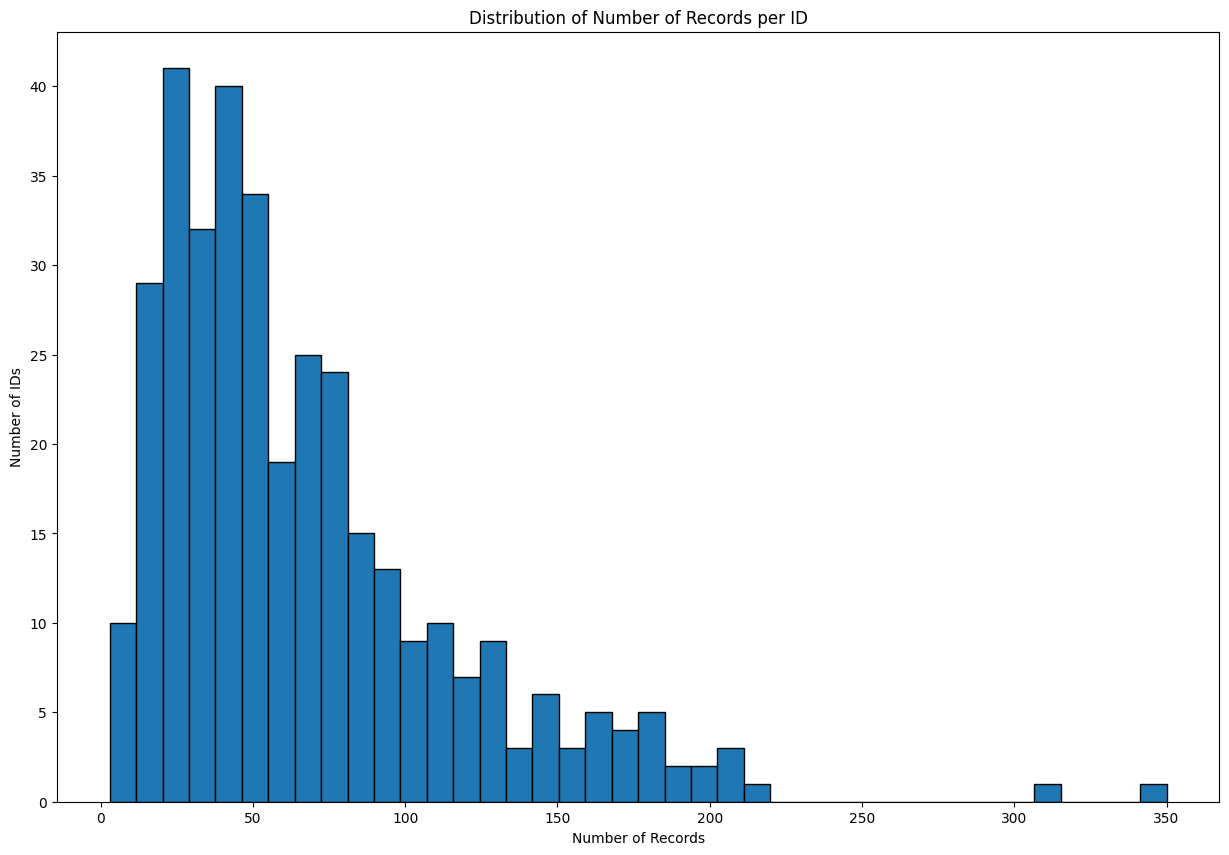

In [458]:
import matplotlib.pyplot as plt

# Calculate the number of records per ID
records_per_id = df['ID'].value_counts()

# Create a histogram
plt.hist(records_per_id, bins=40, edgecolor='black')

# Set the title and labels
plt.title('Distribution of Number of Records per ID')
plt.xlabel('Number of Records')
plt.ylabel('Number of IDs')

# Show the plot
plt.show()

In [459]:
# Group by 'ID' and 'COLLECTED_DATE', and count the number of records in each group
same_day_readings = df.groupby(['ID', 'COLLECTED']).size()

# Find out which IDs had multiple readings on the same day
multiple_same_day_readings = same_day_readings[same_day_readings > 1]

# Print the result
print(multiple_same_day_readings)

ID     COLLECTED          
574    2020-07-14 11:40:00    2
14971  2020-08-11 11:22:00    2
dtype: int64


In [460]:
# Group by 'ID' and find the first 'COLLECTED_DATE' for each group
first_reading_dates = df.groupby('ID')['COLLECTED'].min().reset_index()

# Rename the columns for the join operation
first_reading_dates.columns = ['ID', 'FIRST_READING_DATE']

# Join 'multiple_same_day_readings' with 'first_reading_dates' on 'ID' and 'COLLECTED_DATE'
merged_df = pd.merge(multiple_same_day_readings.reset_index(), first_reading_dates, how='left', left_on=['ID', 'COLLECTED'], right_on=['ID', 'FIRST_READING_DATE'])

# Find out how many of the multiple-reading days were the first day of readings
first_day_multiple_readings = merged_df[merged_df['COLLECTED'] == merged_df['FIRST_READING_DATE']]

# Print the result
print(first_day_multiple_readings)

Empty DataFrame
Columns: [ID, COLLECTED, 0, FIRST_READING_DATE]
Index: []


## 4. Obtain Final Dataframe with the added Kidney Failure Target Variable

In [461]:
df = df_copy

In [462]:
# Create a new column 'Kidney Failure'. If the patient ID is in the list, assign 1, else 0
df['Kidney_Failure'] = df['ID'].isin(patient_ids).astype(int)
df

,COLLECTED,ID,SEX,AGE,INPATIENT/OUTPATIENT,eGFR,Kidney_Failure
1,2019-01-03 12:15:00,2,M,45,OUTPATIENT,23,1
6,2019-01-07 23:05:00,7,M,69,INPATIENT,53,0
9,2019-01-07 23:23:00,10,F,83,INPATIENT,54,0
13,2019-01-07 23:37:00,14,F,65,INPATIENT,48,0
18,2019-01-08 00:10:00,19,M,83,INPATIENT,29,0
...,...,...,...,...,...,...,...
762755,2023-03-31 19:30:00,86286,M,67,INPATIENT,21,0
762763,2023-03-31 20:18:00,7366,M,79,INPATIENT,33,0
762769,2023-03-31 20:33:00,10774,F,56,INPATIENT,85,0
762776,2023-03-31 21:09:00,43998,F,85,INPATIENT,38,0


In [463]:
print("Total number of unique ids:", len(df['ID'].unique()))
print(f"Total number of rows: {len(df)}")
print("Total number of unique ids with KF:", len(df[df['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(df[df['Kidney_Failure']==1])}")

Total number of unique ids: 10064
Total number of rows: 183600
Total number of unique ids with KF: 353
Total number of rows with KF: 23711


In [464]:
df.sort_values(by=['ID', 'COLLECTED'], inplace=True)
df

,COLLECTED,ID,SEX,AGE,INPATIENT/OUTPATIENT,eGFR,Kidney_Failure
1,2019-01-03 12:15:00,2,M,45,OUTPATIENT,23,1
14749,2019-02-08 00:15:00,2,M,46,INPATIENT,19,1
15622,2019-02-10 00:53:00,2,M,46,INPATIENT,17,1
23341,2019-02-25 16:30:00,2,M,46,OUTPATIENT,15,1
26553,2019-03-04 11:00:00,2,M,46,INPATIENT,15,1
...,...,...,...,...,...,...,...
761690,2023-03-30 04:30:00,149302,M,84,INPATIENT,55,0
762302,2023-03-31 05:30:00,149302,M,84,INPATIENT,50,0
761614,2023-03-29 19:40:00,149311,M,72,INPATIENT,55,0
761836,2023-03-30 07:54:00,149311,M,72,INPATIENT,48,0


In [465]:
# Truncate onwards for each ID where the eGFR first drops below 15.
mask = df.groupby('ID')['eGFR'].transform(lambda x: x.ge(15).cummin())
df = df.loc[mask]
df

,COLLECTED,ID,SEX,AGE,INPATIENT/OUTPATIENT,eGFR,Kidney_Failure
1,2019-01-03 12:15:00,2,M,45,OUTPATIENT,23,1
14749,2019-02-08 00:15:00,2,M,46,INPATIENT,19,1
15622,2019-02-10 00:53:00,2,M,46,INPATIENT,17,1
23341,2019-02-25 16:30:00,2,M,46,OUTPATIENT,15,1
26553,2019-03-04 11:00:00,2,M,46,INPATIENT,15,1
...,...,...,...,...,...,...,...
761690,2023-03-30 04:30:00,149302,M,84,INPATIENT,55,0
762302,2023-03-31 05:30:00,149302,M,84,INPATIENT,50,0
761614,2023-03-29 19:40:00,149311,M,72,INPATIENT,55,0
761836,2023-03-30 07:54:00,149311,M,72,INPATIENT,48,0


In [466]:
df_merged = df

# Convert 'COLLECTED' to datetime and sort the dataframe by 'ID' and 'COLLECTED'
df_merged['COLLECTED'] = pd.to_datetime(df_merged['COLLECTED'])
df_merged.sort_values(['ID', 'COLLECTED'], inplace=True)

# Encode 'SEX' as 2 for female and 1 for male
df_merged['SEX'] = df_merged['SEX'].replace({'F': 2, 'M': 1})

# Drop extraneous columns
df_merged = df_merged.drop(columns=['INPATIENT/OUTPATIENT'])

print("Total number of unique ids:", len(df_merged['ID'].unique()))
print(f"Total number of rows: {len(df_merged)}")
print("Total number of unique ids with KF:", len(df_merged[df_merged['Kidney_Failure']==1]['ID'].unique()))
print(f"Total number of rows with KF: {len(df_merged[df_merged['Kidney_Failure']==1])}")

Total number of unique ids: 10064
Total number of rows: 154516
Total number of unique ids with KF: 353
Total number of rows with KF: 5543



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [467]:
# Filter out the rows where Kidney_Failure is 1
kidney_failure_df = df_merged[df_merged['Kidney_Failure'] == 1]

# Find unique male and female IDs with kidney failure
unique_male_ids = kidney_failure_df[kidney_failure_df['SEX'] == 1]['ID'].unique()
unique_female_ids = kidney_failure_df[kidney_failure_df['SEX'] == 2]['ID'].unique()

# Count these unique IDs
male_cases = len(unique_male_ids)
female_cases = len(unique_female_ids)

# Print the counts
print(f"Number of unique male cases of kidney failure: {male_cases}")
print(f"Number of unique female cases of kidney failure: {female_cases}")

Number of unique male cases of kidney failure: 216
Number of unique female cases of kidney failure: 137


# Train and Evaluate Models

### Pre-processing for tree based models

In [468]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

df_merged = df_merged.reset_index(drop=True)
df_merged

def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        return 0.0

    return LinearRegression().fit(x, y).coef_[0]

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

df_merged['COLLECTED'] = df_merged['COLLECTED'].apply(datetime_to_float)

# Group the DataFrame by 'ID'
grouped = df_merged.groupby('ID')

# Compute slopes for each group and directly assign them to the DataFrame
df_merged['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']

# Calculate mean and std for eGFR
df_merged['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
df_merged['eGFR_std'] = grouped['eGFR'].transform(np.std)

# Fill any NaN values that might have cropped up during calculation
df_merged.fillna(0, inplace=True)

# Print the DataFrame after all the calculations
print("TEST_df after assigning eGFR_slope, eGFR_mean, and eGFR_std:")
df_merged

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


TEST_df after assigning eGFR_slope, eGFR_mean, and eGFR_std:


,COLLECTED,ID,SEX,AGE,eGFR,Kidney_Failure,eGFR_slope,eGFR_mean,eGFR_std
0,737062.510417,2,1,45,23,1,-0.045462,18.055556,2.099642
1,737098.010417,2,1,46,19,1,-0.045462,18.055556,2.099642
2,737100.036806,2,1,46,17,1,-0.045462,18.055556,2.099642
3,737115.687500,2,1,46,15,1,-0.045462,18.055556,2.099642
4,737122.458333,2,1,46,15,1,-0.045462,18.055556,2.099642
...,...,...,...,...,...,...,...,...,...
154511,738609.187500,149302,1,84,55,0,-2.396167,52.666667,2.516611
154512,738610.229167,149302,1,84,50,0,-2.396167,52.666667,2.516611
154513,738608.819444,149311,1,72,55,0,-3.435050,50.666667,3.785939
154514,738609.329167,149311,1,72,48,0,-3.435050,50.666667,3.785939


In [469]:
from pandas.tseries.offsets import DateOffset
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

TEST_df = TEST_df.reset_index(drop=True)
TEST_df

# Function to convert Time to months
def convert_to_months(time_str):
    if time_str == 'eGFR(last visit)':
        return 42
    else:
        return int(time_str.split('(')[-1].split('M')[0])

# Apply the function to the 'Time' column to create a new 'Months' column
TEST_df['Months'] = TEST_df['Time'].apply(convert_to_months)

# Assume a starting date for all IDs
start_date = pd.Timestamp('2020-01-01')

# Create a 'COLLECTED' column based on the 'Months' column
TEST_df['COLLECTED'] = TEST_df.apply(lambda row: start_date + DateOffset(months=row['Months']), axis=1)
TEST_df

def compute_slope(group):
    x = np.array(group['COLLECTED']).reshape(-1, 1)
    y = np.array(group['eGFR'])

    if len(x) < 2:
        return 0.0

    return LinearRegression().fit(x, y).coef_[0]

# Convert 'COLLECTED' to ordinal for calculation purposes
def datetime_to_float(d):
    return d.toordinal() + d.hour/24.0 + d.minute/(24*60) + d.second/(24*60*60)

TEST_df['COLLECTED'] = TEST_df['COLLECTED'].apply(datetime_to_float)

# Group the DataFrame by 'ID'
grouped = TEST_df.groupby('ID')

# Compute slopes for each group and directly assign them to the DataFrame
TEST_df['eGFR_slope'] = grouped.apply(lambda group: group.assign(slope=compute_slope(group)))['slope']

# Calculate mean and std for eGFR
TEST_df['eGFR_mean'] = grouped['eGFR'].transform(np.mean)
TEST_df['eGFR_std'] = grouped['eGFR'].transform(np.std)

print(TEST_df.isna().sum())

# Fill any NaN values that might have cropped up during calculation
TEST_df.fillna(0, inplace=True)

# Print the DataFrame after all the calculations
print("TEST_df after assigning eGFR_slope, eGFR_mean, and eGFR_std:")
TEST_df

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)


ID                 0
SEX                0
Time               0
AGE                0
eGFR               0
Kidney_Failure     0
Months             0
COLLECTED          0
eGFR_slope         0
eGFR_mean          0
eGFR_std          49
dtype: int64
TEST_df after assigning eGFR_slope, eGFR_mean, and eGFR_std:


,ID,SEX,Time,AGE,eGFR,Kidney_Failure,Months,COLLECTED,eGFR_slope,eGFR_mean,eGFR_std
0,10101,2,eGFR(0M),74,44.685607,0,0,737425.0,-0.015137,29.643276,7.328739
1,10101,2,eGFR(6M),74,33.702778,0,6,737607.0,-0.015137,29.643276,7.328739
2,10101,2,eGFR(12M),75,30.641655,0,12,737791.0,-0.015137,29.643276,7.328739
3,10101,2,eGFR(18M),75,31.129969,0,18,737972.0,-0.015137,29.643276,7.328739
4,10101,2,eGFR(24M),76,26.807906,0,24,738156.0,-0.015137,29.643276,7.328739
...,...,...,...,...,...,...,...,...,...,...,...
3383,160112,1,eGFR(18M),53,35.133304,0,18,737972.0,-0.001151,36.370115,2.238376
3384,160112,1,eGFR(24M),54,35.502557,0,24,738156.0,-0.001151,36.370115,2.238376
3385,160112,1,eGFR(30M),54,33.338440,0,30,738337.0,-0.001151,36.370115,2.238376
3386,160112,1,eGFR(36M),55,36.758771,0,36,738521.0,-0.001151,36.370115,2.238376


### TUNED HYPERPARAMTER MODEL - AU Dataset

In [470]:
# import numpy as np
# import pandas as pd
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
# from sklearn.model_selection import train_test_split
# import random

# # Adjust this threshold as needed
# threshold = 0.5

# # Create an empty dictionary to store ensemble components as well as their test statistics
# ensemble = {}

# features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
# X = df_merged[features]
# y = df_merged['Kidney_Failure']

# # Create a dataframe to store the results
# df_results = pd.DataFrame(columns=['TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'TPR', 'TNR', 'FPR', 'FNR', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'ROC-AUC'])

# # Here we are varying the training and testing sets
# for seed_value in range(10):
#     random.seed(seed_value)
#     np.random.seed(seed_value)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed_value, stratify=y)

#     # Define the model
#     model = DecisionTreeClassifier(random_state=seed_value)
#     model.fit(X_train, y_train)

#     # Make predictions
#     predictions = model.predict(X_test)
#     predicted_probabilities = model.predict_proba(X_test)[:,1]  # Assuming class 1 is the positive class

#     # Apply threshold
#     predicted_labels = (predicted_probabilities >= threshold).astype(int)

#     # Compute statistics
#     true_positives = np.sum((predicted_labels == 1) & (y_test == 1))
#     true_negatives = np.sum((predicted_labels == 0) & (y_test == 0))
#     false_positives = np.sum((predicted_labels == 1) & (y_test == 0))
#     false_negatives = np.sum((predicted_labels == 0) & (y_test == 1))

#     tpr = true_positives / (true_positives + false_negatives)
#     tnr = true_negatives / (true_negatives + false_positives)
#     fpr = false_positives / (false_positives + true_negatives)
#     fnr = false_negatives / (false_negatives + true_positives)
#     accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
#     precision = precision_score(y_test, predicted_labels)
#     recall = recall_score(y_test, predicted_labels)
#     specificity = tnr
#     roc_auc = roc_auc_score(y_test, predicted_probabilities)

#     df_results.loc[seed_value] = [true_positives, true_negatives, false_positives, false_negatives, tpr, tnr, fpr, fnr, accuracy, precision, recall, specificity, roc_auc]

#     ensemble[seed_value] = {'model': model,
#                             'test_statistics': {'true_positives': true_positives,
#                                                 'true_negatives': true_negatives,
#                                                 'false_positives': false_positives,
#                                                 'false_negatives': false_negatives,
#                                                 'tpr': tpr, 'tnr': tnr, 'fpr': fpr, 'fnr': fnr,
#                                                 'accuracy': accuracy,
#                                                 'precision': precision,
#                                                 'recall': recall,
#                                                 'specificity': specificity,
#                                                 'roc_auc': roc_auc}}

# # Print the average of each statistic over the 10 runs
# print(df_results.mean())

In [471]:
#ensemble

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
import random

# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# Create a dataframe to store the results
df_results = pd.DataFrame(columns=['TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives',
                                   'TPR', 'TNR', 'FPR', 'FNR',
                                   'Accuracy', 'Precision', 'Recall', 'f1_score', 'Specificity', 'ROC-AUC'])

# Sample dataset features and target
features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
X = df_merged[features]
y = df_merged['Kidney_Failure']

# Initialize accumulators for confusion matrix elements
total_true_positives = 0
total_true_negatives = 0
total_false_positives = 0
total_false_negatives = 0

# Initialize a Decision Tree model
clf = DecisionTreeClassifier(random_state=seed_value)

param_grid = {
    #'ccp_alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    #'max_features': ['auto', 'sqrt', 'log2', None],
    #'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'class_weight': ['balanced', None]
}


# Initialize GridSearch
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value),
                           scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit the GridSearch model
grid_search.fit(X, y)

# Extract the best estimator
best_clf = grid_search.best_estimator_

# Use Stratified KFold for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_value)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train a Decision Tree model using the best estimator
    best_clf.fit(X_train, y_train)

    # Evaluate on the held-out test set
    y_pred = best_clf.predict(X_test)
    print("Final Accuracy:", accuracy_score(y_test, y_pred))
    print("Final Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Final ROC-AUC Score:")
    print(roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1]))

    # Compute the statistics
    true_positives = np.sum((y_pred == 1) & (y_test == 1))
    true_negatives = np.sum((y_pred == 0) & (y_test == 0))
    false_positives = np.sum((y_pred == 1) & (y_test == 0))
    false_negatives = np.sum((y_pred == 0) & (y_test == 1))

    # Accumulate confusion matrix values
    total_true_positives += true_positives
    total_true_negatives += true_negatives
    total_false_positives += false_positives
    total_false_negatives += false_negatives

    # Print individual metrics
    tpr = true_positives / (true_positives + false_negatives)
    tnr = true_negatives / (true_negatives + false_positives)
    fpr = false_positives / (false_positives + true_negatives)
    fnr = false_negatives / (false_negatives + true_positives)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_score = 2 * precision * recall / (precision + recall)
    specificity = true_negatives / (true_negatives + false_positives)
    roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])

    print(accuracy, precision, recall, f1_score, specificity, roc_auc)

    # Add the statistics to the dataframe
    df_results.loc[len(df_results)] = [true_positives, true_negatives, false_positives, false_negatives, tpr, tnr, fpr, fnr, accuracy, precision, recall, f1_score, specificity, roc_auc]

# Compute mean confusion matrix values
mean_true_positives = total_true_positives / n_splits
mean_true_negatives = total_true_negatives / n_splits
mean_false_positives = total_false_positives / n_splits
mean_false_negatives = total_false_negatives / n_splits

# Construct the mean confusion matrix
mean_confusion_matrix = np.array([[mean_true_negatives, mean_false_positives],
                                 [mean_false_negatives, mean_true_positives]])

# Plot the mean confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=mean_confusion_matrix, display_labels=['No Failure', 'Kidney Failure'])
cm_display.plot(cmap='Blues')  # Using the 'Blues' colormap
plt.title('Mean Confusion Matrix')
plt.show()

# Print the average of each statistic over the 5 folds
print(df_results.mean())

# Print out the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [ ]:
# Train the final model on the full Australian dataset
best_clf = DecisionTreeClassifier(**best_params, random_state=seed_value)
best_clf.fit(X, y)

In [ ]:
# Get feature importances
importances = best_clf.feature_importances_

# Pair feature names with their importance values
feature_importance_pairs = list(zip(features, importances))

# Sort by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display the sorted features and their importances
for rank, (feature, importance) in enumerate(sorted_feature_importance_pairs, start=1):
    print(f"{rank}.\tfeature {feature} ({importance:.6f})")

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is your trained decision tree
plt.figure(figsize=(400, 30))  # adjust the size as needed
plot_tree(best_clf, filled=True, feature_names=features, class_names=str(best_clf.classes_), rounded=True, fontsize=10)
plt.show()

In [ ]:
from sklearn.tree import _tree

def tree_to_ifelse(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold:.2f}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else: # if {name} > {threshold:.2f}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return class = {tree_.value[node].argmax()}")

    recurse(0, 0)

# Using the function
tree_to_ifelse(best_clf, features)

### HELD-OUT TEST DATA - Tuned Model (Without Fine-Tuning)

In [110]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, accuracy_score
import random

# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# Adjust this threshold as needed
threshold = 0.5

# Dataset features and target
features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
X_test = TEST_df[features]
y_test = TEST_df['Kidney_Failure']

# Evaluate on the held-out test set
clf = best_clf

y_pred = clf.predict(X_test)
print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("Final Classification Report:")
print(classification_report(y_test, y_pred))
print("Final ROC-AUC Score:")
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# Compute the statistics
true_positives = np.sum((y_pred == 1) & (y_test == 1))
true_negatives = np.sum((y_pred == 0) & (y_test == 0))
false_positives = np.sum((y_pred == 1) & (y_test == 0))
false_negatives = np.sum((y_pred == 0) & (y_test == 1))

# Print individual metrics
tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = 2 * precision * recall / (precision + recall)
specificity = true_negatives / (true_negatives + false_positives)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print("TPR:", tpr, "TNR:", tnr, "FPR:", fpr, "FNR:", fnr,
      '\n' "Accuracy", accuracy, "Precision:", precision, "Recall:", recall, "F1 Score:", f1_score, "Specificity:", specificity, "ROC-AUC:", roc_auc)

Final Accuracy: 0.8745572609208973
Final Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2932
           1       0.54      0.41      0.47       456

    accuracy                           0.87      3388
   macro avg       0.73      0.68      0.70      3388
weighted avg       0.86      0.87      0.87      3388

Final ROC-AUC Score:
0.6990097921303943
TPR: 0.4144736842105263 TNR: 0.9461118690313779 FPR: 0.0538881309686221 FNR: 0.5855263157894737 
Accuracy 0.8745572609208973 Precision: 0.5446685878962536 Recall: 0.4144736842105263 F1 Score: 0.4707347447073475 Specificity: 0.9461118690313779 ROC-AUC: 0.6990097921303943


### HELD-OUT TEST DATA - Tuned Model (with Fine Tuning)

Final Accuracy: 0.9333333333333333
Final Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2492
           1       0.74      0.77      0.76       388

    accuracy                           0.93      2880
   macro avg       0.85      0.87      0.86      2880
weighted avg       0.93      0.93      0.93      2880

Final ROC-AUC Score:
0.9444583491916401
TPR: 0.7731958762886598 TNR: 0.9582664526484751 FPR: 0.04173354735152488 FNR: 0.2268041237113402 
Accuracy 0.9333333333333333 Precision: 0.7425742574257426 Recall: 0.7731958762886598 F1 Score: 0.7575757575757575 Specificity: 0.9582664526484751 ROC-AUC: 0.9444583491916401


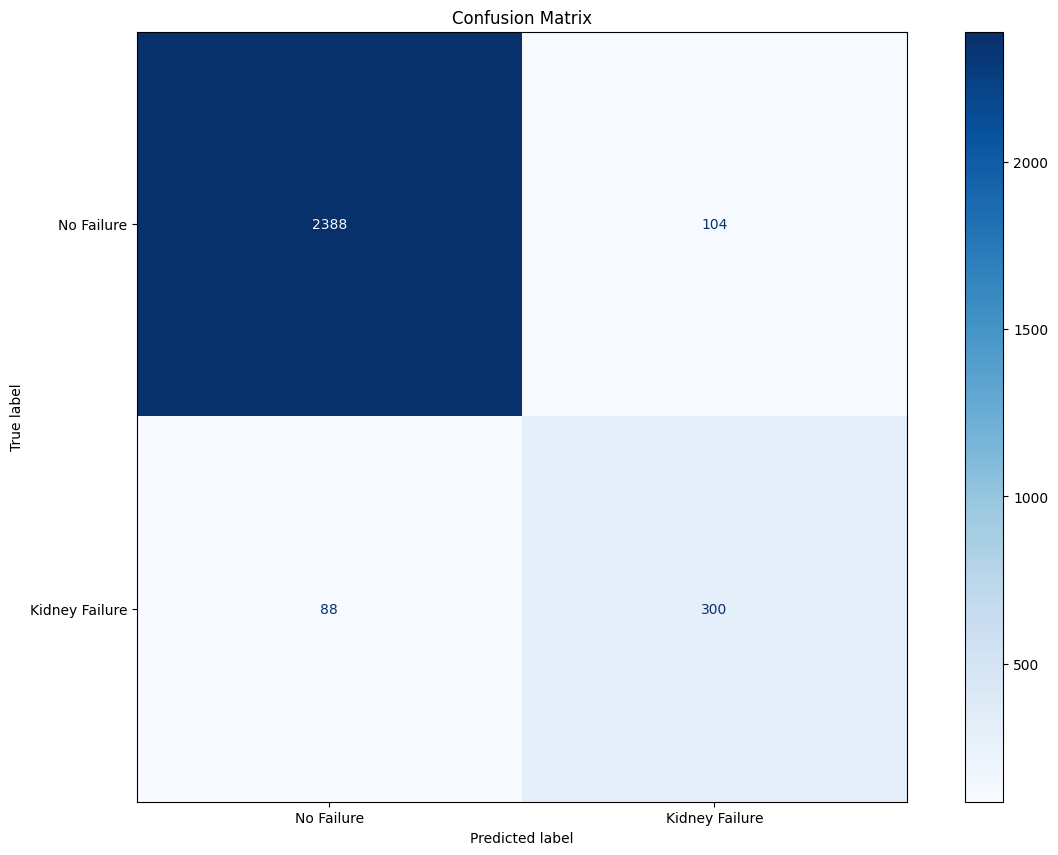

In [386]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, accuracy_score
import random
from sklearn import metrics
import matplotlib.pyplot as plt

# Set random seeds
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)

# CHANGING TO TUNED MODEL
clf = best_clf

# Adjust this threshold as needed
threshold = 0.5

# Dataset features and target
features = ['AGE', 'SEX', 'eGFR_slope', 'eGFR_mean']
X = TEST_df[features]
y = TEST_df['Kidney_Failure']

# Train the model on 15% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=seed_value, stratify=y)
clf.fit(X_train, y_train)

# Evaluate on the held-out test set
y_pred = clf.predict(X_test)
print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("Final Classification Report:")
print(classification_report(y_test, y_pred))
print("Final ROC-AUC Score:")
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# Compute the statistics
true_positives = np.sum((y_pred == 1) & (y_test == 1))
true_negatives = np.sum((y_pred == 0) & (y_test == 0))
false_positives = np.sum((y_pred == 1) & (y_test == 0))
false_negatives = np.sum((y_pred == 0) & (y_test == 1))

# Print individual metrics
tpr = true_positives / (true_positives + false_negatives)
tnr = true_negatives / (true_negatives + false_positives)
fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = 2 * precision * recall / (precision + recall)
specificity = true_negatives / (true_negatives + false_positives)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print("TPR:", tpr, "TNR:", tnr, "FPR:", fpr, "FNR:", fnr,
      '\n' "Accuracy", accuracy, "Precision:", precision, "Recall:", recall, "F1 Score:", f1_score, "Specificity:", specificity, "ROC-AUC:", roc_auc)

# Plot the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['No Failure', 'Kidney Failure'])

cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [387]:
# Get feature importances
importances = best_clf.feature_importances_

# Pair feature names with their importance values
feature_importance_pairs = list(zip(features, importances))

# Sort by importance
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display the sorted features and their importances
for rank, (feature, importance) in enumerate(sorted_feature_importance_pairs, start=1):
    print(f"{rank}.\tfeature {feature} ({importance:.6f})")

1.	feature eGFR_slope (0.507686)
2.	feature eGFR_mean (0.450605)
3.	feature AGE (0.041708)
4.	feature SEX (0.000000)


In [388]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is your trained decision tree
plt.figure(figsize=(400, 30))  # adjust the size as needed
plot_tree(best_clf, filled=True, feature_names=features, class_names=str(best_clf.classes_), rounded=True, fontsize=10)
plt.show()

In [389]:
from sklearn.tree import _tree

def tree_to_ifelse(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if {name} <= {threshold:.2f}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else: # if {name} > {threshold:.2f}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            print(f"{indent}return class = {tree_.value[node].argmax()}")

    recurse(0, 0)

# Using the function
tree_to_ifelse(best_clf, features)

if eGFR_mean <= 25.07:
  if eGFR_slope <= -0.01:
    if eGFR_slope <= -0.01:
      return class = 1
    else: # if eGFR_slope > -0.01
      if eGFR_slope <= -0.01:
        return class = 0
      else: # if eGFR_slope > -0.01
        return class = 1
  else: # if eGFR_slope > -0.01
    if eGFR_mean <= 18.39:
      if eGFR_slope <= 0.00:
        if AGE <= 80.50:
          return class = 1
        else: # if AGE > 80.50
          return class = 0
      else: # if eGFR_slope > 0.00
        return class = 0
    else: # if eGFR_mean > 18.39
      if eGFR_slope <= -0.00:
        if eGFR_mean <= 24.86:
          return class = 0
        else: # if eGFR_mean > 24.86
          return class = 1
      else: # if eGFR_slope > -0.00
        if eGFR_slope <= -0.00:
          return class = 1
        else: # if eGFR_slope > -0.00
          if eGFR_mean <= 20.31:
            return class = 1
          else: # if eGFR_mean > 20.31
            if eGFR_slope <= 0.01:
              if eGFR_slope <= -0.00:


In [390]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# Create an explainer object
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=features,
                                 class_names=['No Kidney Failure', 'Kidney Failure'],
                                 discretize_continuous=True)

# Get an instance to interpret
i = random.randint(0, len(X_test)-1)
exp = explainer.explain_instance(X_test.iloc[i].values, best_clf.predict_proba)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)

true_value = y_test.iloc[i]
print(f"True Value for instance {i}: {true_value}")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10) # Set the desired width and height

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


True Value for instance 1577: 0


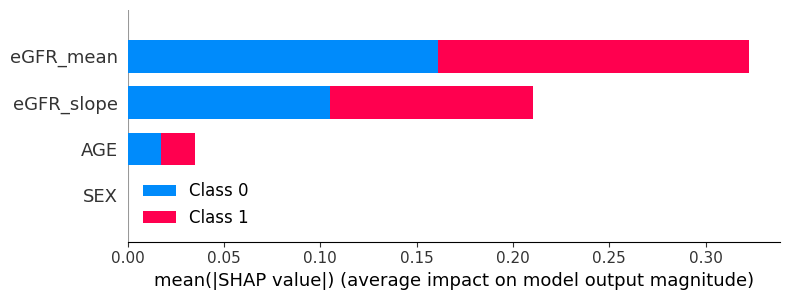

In [391]:
import shap

# Initialize SHAP's tree explainer with the model
explainer = shap.TreeExplainer(best_clf)

# Compute SHAP values for a sample from the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=features)

# For individual predictions, you can use a force plot
# Here, for instance 'i' from LIME example
shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], X_test.iloc[i,:])


# Data Analysis

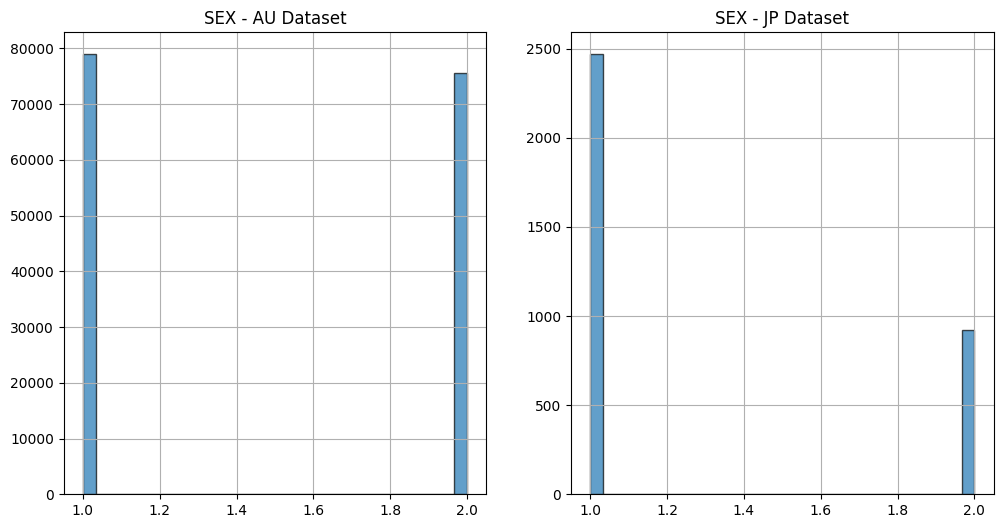

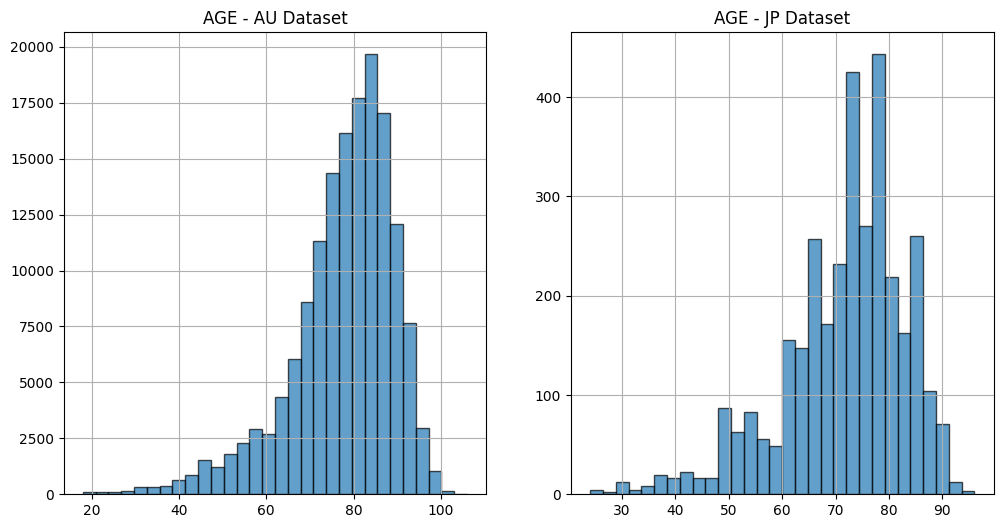

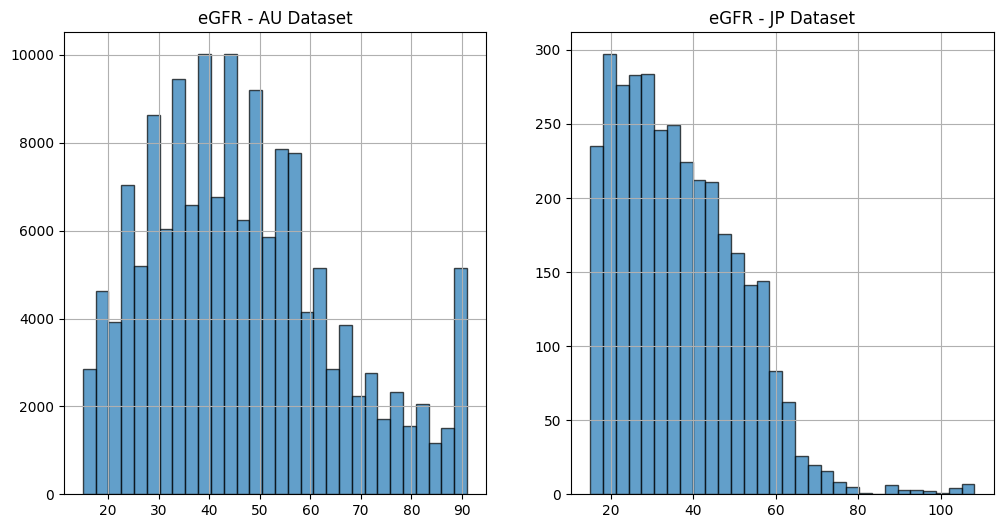

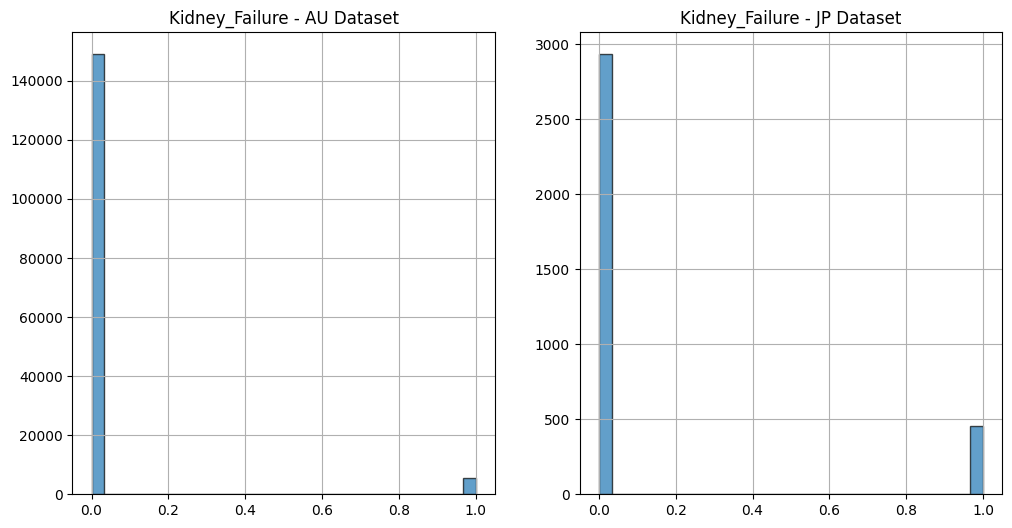

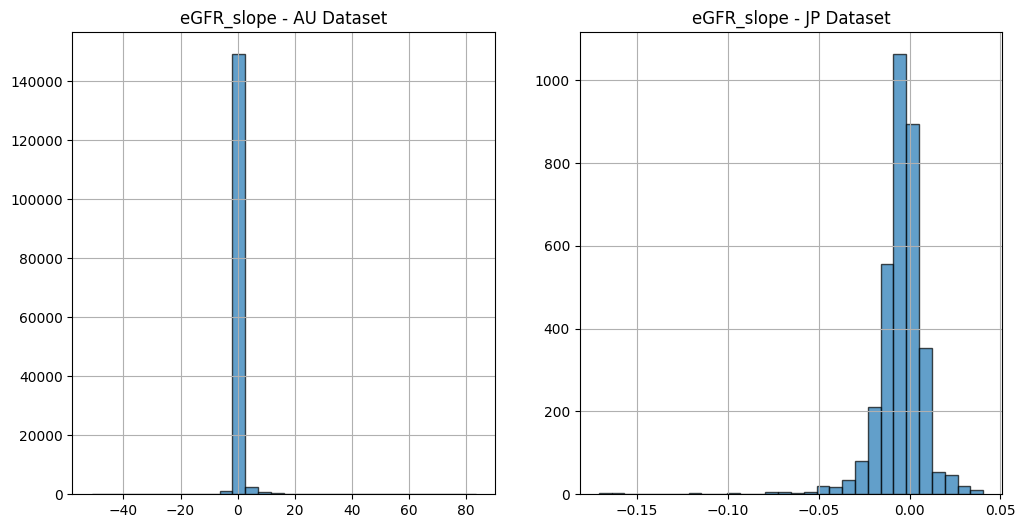

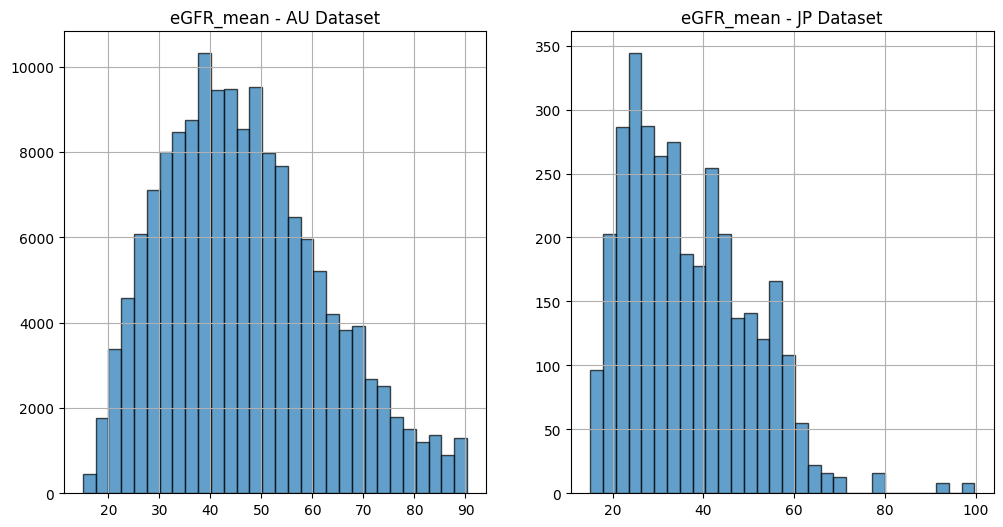

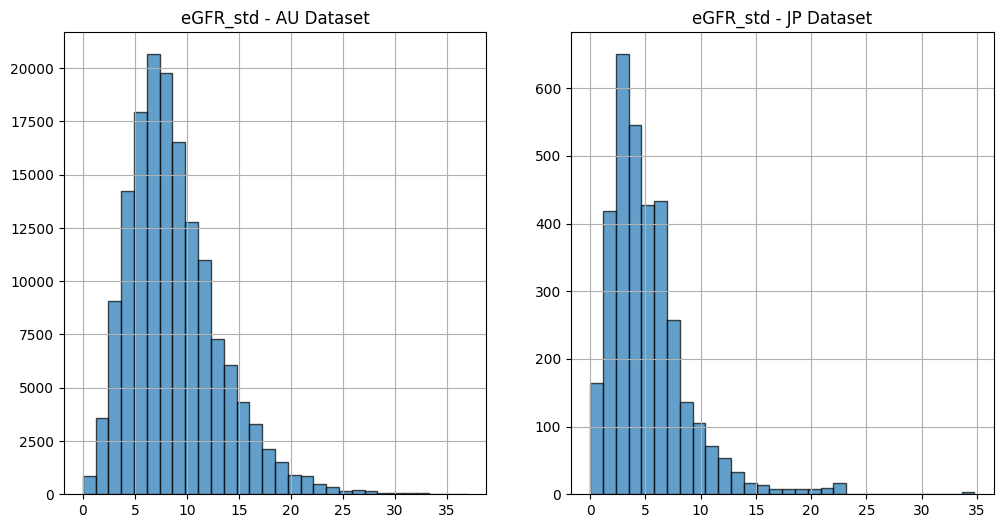

Summary statistics for AU Dataset:
                 SEX            AGE           eGFR  Kidney_Failure  \
count  154516.000000  154516.000000  154516.000000   154516.000000   
mean        1.489095      77.538371      46.642956        0.035873   
std         0.499883      12.017280      18.364515        0.185975   
min         1.000000      18.000000      15.000000        0.000000   
25%         1.000000      72.000000      33.000000        0.000000   
50%         1.000000      80.000000      44.000000        0.000000   
75%         2.000000      86.000000      58.000000        0.000000   
max         2.000000     106.000000      91.000000        1.000000   

          eGFR_slope      eGFR_mean       eGFR_std  
count  154516.000000  154516.000000  154516.000000  
mean        0.165648      46.642956       8.778338  
std         1.869981      15.705679       4.381331  
min       -51.135708      15.000000       0.000000  
25%        -0.014577      34.750000       5.718781  
50%        -0.00

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_merged and TEST_df are already loaded DataFrames
# Select the features you are interested in
features = ['SEX', 'AGE', 'eGFR', 'Kidney_Failure', 'eGFR_slope', 'eGFR_mean', 'eGFR_std']

# Iterate over each feature and plot the distribution for both datasets
for feature in features:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    df_merged[feature].hist(bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'{feature} - AU Dataset')

    plt.subplot(1, 2, 2)
    TEST_df[feature].hist(bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'{feature} - JP Dataset')

    plt.show()

# Display summary statistics for both datasets
print("Summary statistics for AU Dataset:")
print(df_merged[features].describe())

print("\nSummary statistics for JP Dataset:")
print(TEST_df[features].describe())